# Chessboard Vision Project  

## 📌 Introduction  
This project is part of the **Computer Vision** course in the Master's in Artificial Intelligence. The goal is to detect chess pieces on a board from images, determine their positions using bounding boxes, and represent them in an 8x8 matrix format. The solution is implemented in Python and follows a structured image processing pipeline.

## 🎯 Task Overview  
- **Input:** Chessboard image  
- **Output:**  
  - Total number of black/white pieces  
  - Bounding boxes around detected pieces  
  - 8x8 matrix representing piece positions  
- **Dataset:** 50 images for development, 10 unseen test images  
- **Deliverables:**  
  - Python script (single file)  
  - Short report (max 2 pages) 

---

In [81]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import math

# Data Directory
dataDir = 'images'

# Define the window size
window_width = 800
window_height = 600

In [82]:
# Function to resize image
def resize_image(image, window_width, window_height):
    height, width = image.shape[:2]
    scaling_factor = min(window_width / width, window_height / height)
    return cv2.resize(image, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)

Image Dimensions: 3024 x 3024
Number of Channels: 3


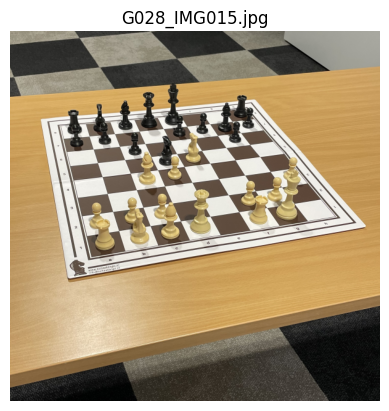

In [83]:
# Read and Display an Image
# Opening an image
img = cv2.imread(os.path.join(dataDir, 'G028_IMG015.jpg'))

# Get the dimensions of the image
height, width, channels = img.shape
print(f'Image Dimensions: {height} x {width}')
print(f'Number of Channels: {channels}')

# Calculate the scaling factor
scaling_factor = min(window_width / width, window_height / height)

# Resize the image
resized_img = resize_image(img, window_width, window_height)

# Display the resized image using matplotlib
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
plt.title('G028_IMG015.jpg')
plt.axis('off')
plt.show()

In [84]:
def detect_chessboard_improved(image):
    """
    Detect the chessboard in an image using color segmentation and corner approximation
    
    Args:
        image: Input image in BGR format
    
    Returns:
        original image with contour drawn, isolated chessboard, detected corners, mask
    """
    # Convert image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Create a mask for light colors (white border of the chessboard)
    lower_white = np.array([0, 0, 180])  # Adjusted threshold to be more sensitive
    upper_white = np.array([180, 50, 255])  # Slightly increased saturation range
    
    mask = cv2.inRange(hsv, lower_white, upper_white)
    
    # Perform morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # Additional dilation to connect potentially broken contours
    mask = cv2.dilate(mask, kernel, iterations=2)
    
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # If no contours found, return original image and empty contour
    if not contours:
        return image, image.copy(), None, mask
    
    # Find the largest contour (assumed to be the chessboard)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Create a copy of the original image to draw on
    result = image.copy()
    
    # Approximate the contour to get a simpler polygon
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)
    
    # Get the best four corners even if the shape is not exactly a quadrilateral
    corners = get_four_corners(approx, image.shape[:2])
    
    # Draw the detected corners on the result image
    for corner in corners:
        cv2.circle(result, tuple(corner), 10, (0, 0, 255), -1)
    
    # Draw the contour on the image
    cv2.drawContours(result, [np.array(corners)], -1, (0, 255, 0), 3)
    
    # Apply perspective transform to get the isolated chessboard
    isolated_board = four_point_transform(image, np.array(corners))
    
    return result, isolated_board, corners, mask

def get_four_corners(contour, image_shape):
    """
    Extract or approximate the four corners of a chessboard from a contour.
    
    Args:
        contour: The detected contour
        image_shape: Image height and width
    
    Returns:
        List of four corner points in clockwise order [top-left, top-right, bottom-right, bottom-left]
    """
    # If we already have exactly 4 points, check if they form a reasonable quadrilateral
    if len(contour) == 4:
        return sort_corners(contour.reshape(4, 2))
    
    # If we have more than 4 points, try to find the best 4 corners
    hull = cv2.convexHull(contour)
    epsilon = 0.03 * cv2.arcLength(hull, True)  # Increased epsilon for better approximation
    approx = cv2.approxPolyDP(hull, epsilon, True)
    
    # If approximation gives us exactly 4 points, use them
    if len(approx) == 4:
        return sort_corners(approx.reshape(4, 2))
    
    # Fallback: Use extreme points (leftmost, rightmost, topmost, bottommost)
    h, w = image_shape
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int32(box)  # Convert to integer
    return sort_corners(box)

def sort_corners(pts):
    """
    Sort corners in clockwise order starting from top left.
    
    Args:
        pts: Array of 4 points
    
    Returns:
        Sorted array of points
    """
    # Convert points to list if they're not already
    pts = pts.tolist() if not isinstance(pts[0], list) else pts
    
    # Sort points by x-coordinate
    pts.sort(key=lambda x: x[0])
    
    # Get left-side and right-side points
    left_side = pts[:2]
    right_side = pts[2:]
    
    # Sort left-side points by y-coordinate
    left_side.sort(key=lambda x: x[1])
    top_left, bottom_left = left_side
    
    # Sort right-side points by y-coordinate
    right_side.sort(key=lambda x: x[1])
    top_right, bottom_right = right_side
    
    return [top_left, top_right, bottom_right, bottom_left]

def four_point_transform(image, pts):
    """
    Apply perspective transformation to obtain a top-down view of the chessboard.
    
    Args:
        image: Input image
        pts: Four corner points of the chessboard
    
    Returns:
        Transformed image (top-down view of the chessboard)
    """
    # Define the output image size (assuming a square chessboard)
    width = height = max(
        np.linalg.norm(pts[0] - pts[1]),
        np.linalg.norm(pts[1] - pts[2]),
        np.linalg.norm(pts[2] - pts[3]),
        np.linalg.norm(pts[3] - pts[0])
    )
    width = int(width)
    height = int(height)
    
    # Define the destination points for the perspective transform
    dst = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype="float32")
    
    # Convert corners to float32
    pts = np.array(pts, dtype="float32")
    
    # Compute the perspective transform matrix
    M = cv2.getPerspectiveTransform(pts, dst)
    
    # Apply the perspective transformation
    warped = cv2.warpPerspective(image, M, (width, height))
    
    return warped

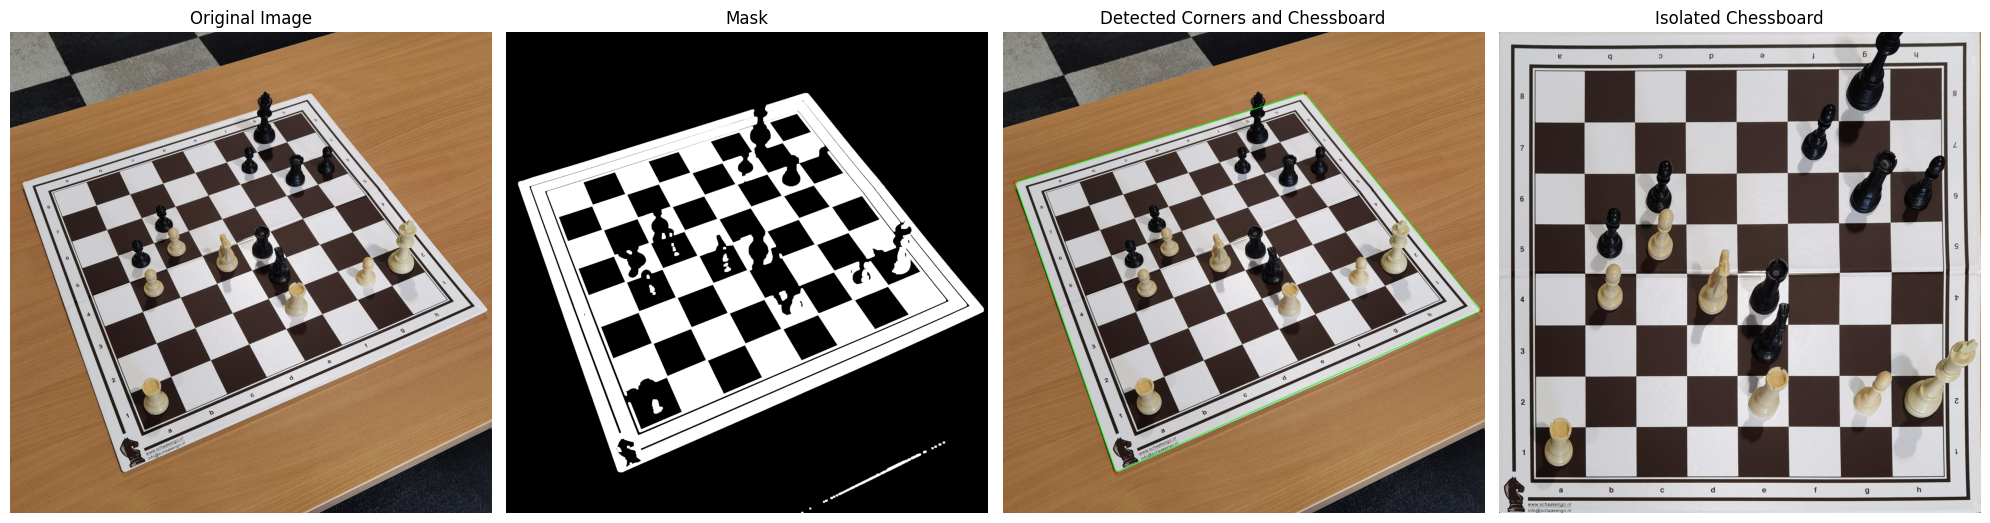

Detected corners for G000_IMG062.jpg: [[77, 966], [1925, 397], [3045, 1783], [720, 2811]]


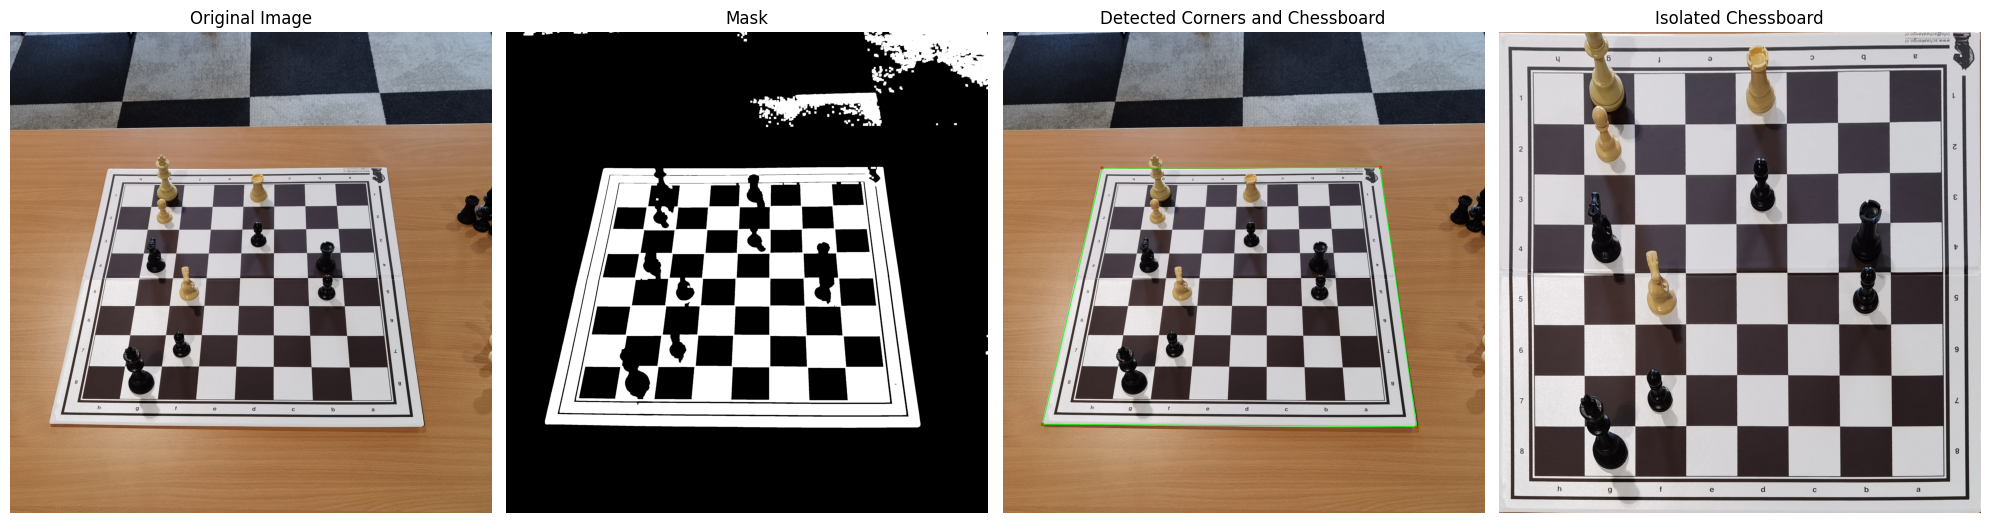

Detected corners for G000_IMG087.jpg: [[632, 873], [2404, 870], [2635, 2521], [252, 2506]]


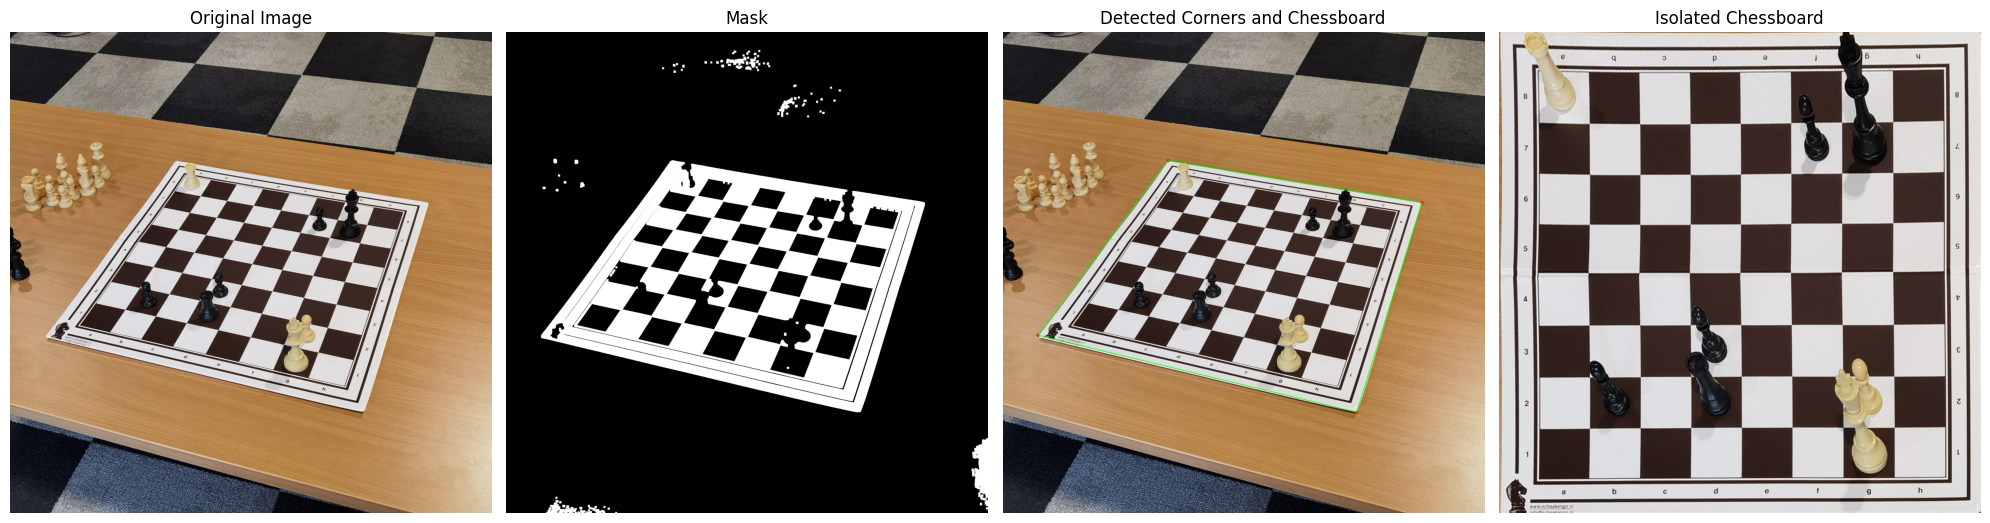

Detected corners for G000_IMG102.jpg: [[1052, 826], [2669, 1094], [2254, 2429], [223, 1939]]


KeyboardInterrupt: 

In [85]:
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob

# Define the directory containing the images
dataDir = 'images'

# Get a list of all image file paths in the directory
image_paths = glob(os.path.join(dataDir, '*.jpg'))  # Adjust extension if needed (e.g., '*.png')

# Loop through each image in the directory
for image_path in image_paths:
    # Read the image
    img = cv2.imread(image_path)
    
    # Check if the image was loaded successfully
    if img is None:
        print(f"Failed to load image: {image_path}")
        continue
    
    # Apply the improved chessboard detection function
    result_improved, isolated_board, corners, mask = detect_chessboard_improved(img)

    # Display the results
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(cv2.cvtColor(result_improved, cv2.COLOR_BGR2RGB))
    plt.title('Detected Corners and Chessboard')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    if isolated_board is not None:
        plt.imshow(cv2.cvtColor(isolated_board, cv2.COLOR_BGR2RGB))
        plt.title('Isolated Chessboard')
    else:
        plt.text(0.5, 0.5, 'No Chessboard Detected', fontsize=12, ha='center')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    # Display corner information
    if corners is not None:
        print(f"Detected corners for {os.path.basename(image_path)}: {corners}")
    else:
        print(f"No corners detected for {os.path.basename(image_path)}")